# Analiza retrospektywna bólu moszny

Ten notatnik zawiera analizę zbioru danych sp_retro, który obejmuje dane pacjentów z bólem moszny zebrane w 2003 roku. Celem jest zbudowanie klasyfikatora binarnego wspierającego decyzje triaży na oddziale ratunkowym szpitala pediatrycznego.

## Opis zadania
Budujemy model uczenia maszynowego do klasyfikacji pacjentów na dwie kategorie:
- Klasa pozytywna (1): CONSULT (najważniejsza klinicznie klasa)
- Klasa negatywna (0): DISCHARGE + CLINIC (przypadki mniej pilne)

Ocena zostanie przeprowadzona przy użyciu 3-krotnej stratyfikowanej walidacji krzyżowej z 5 podziałami oraz progami stratyfikacji ryzyka.

In [376]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


from sklearn.model_selection import (
    RepeatedStratifiedKFold, GridSearchCV
)
from sklearn.metrics import (
    precision_recall_curve, auc, roc_curve
)

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, QuantileTransformer, 
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    SelectFromModel
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [377]:
def read_dataset(file_path = 'sp_retro_data.xls'):

    data = pd.read_excel(
        file_path,
        header=0,
        skiprows=2,  # Pomiń pierwsze dwa wiersze (zawierają metadane)
        sheet_name='Discretized Data (Final)',
        na_values=['?'],  # Konwertuj '?' na NaN
        engine='xlrd')
    return data

def visualize(data):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='binary_target', data=data, palette='viridis', dodge=False)
    plt.title('Rozkład zmiennej celu')
    plt.xlabel('Klasa (1: KONSULTACJA, 0: WYPIS+KLINIKA)')
    plt.ylabel('Liczba przypadków')

    # Dodaj etykiety procentowe do każdego słupka
    total = len(data)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 5
        ax.annotate(percentage, (x, y), ha='center')

    plt.show()

## 1. Eksploracja danych

Zbadajmy zbiór danych, aby zrozumieć jego strukturę, rozmiar i charakterystykę. Ten krok jest kluczowy dla zrozumienia materiału, z którym pracujemy, przed przystąpieniem do budowy modelu.

In [378]:
data = read_dataset('sp_retro_data.xls')
print(f"Początkowy kształt danych: {data.shape}")
print("Pierwsze kilka wierszy surowych danych:")
display(data.head())

Początkowy kształt danych: (409, 31)
Pierwsze kilka wierszy surowych danych:


,NUMBER,AGE,HX_AS,NAUSEA,VOMIT,NAUSEA_OR_VOMIT,ABD_PAIN,ONSET,PAIN_TYPE,DURATION,...,SITE_SWELLING,COLOR,TEST_LIE,CORD_PALP,CREM_REF,TRANSILLUM,URINE_WBC,URINE_BACT,URINE_RBC,TRIAGE
0,1,LT10Y,NaN,NaN,NO,NONE,YES,NaN,NaN,LT6H,...,OSC,NaN,NaN,ABNORMAL,NaN,NaN,NaN,NaN,NaN,CLINIC
1,2,GE10Y_LE13Y,NaN,NaN,NaN,NaN,YES,SUDDEN,NaN,GE6H_LE24H,...,OSC,ERYTHEMA,NORMAL,NORMAL,YES,YES,NEG_0_5,NEG,NEG_0_5,CLINIC
2,3,GT13Y,NO,YES,YES,VOMIT,NaN,SUDDEN,NaN,GE6H_LE24H,...,TESTICLE,NORMAL,NaN,NaN,NaN,NaN,NEG_0_5,POS,NEG_0_5,CONSULT
3,4,GT13Y,NaN,NaN,YES,VOMIT,YES,NaN,CONSTANT,GT24H,...,NONE,ERYTHEMA,NaN,NORMAL,NaN,NaN,NEG_0_5,NaN,NEG_0_5,DISCHARGE
4,5,LT10Y,NaN,NaN,NO,NONE,YES,GRADUAL,NaN,LT6H,...,NONE,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DISCHARGE


In [379]:
# Usuń kolumny z tylko jedną unikalną wartością
for col in data.columns:
    if data[col].nunique() == 1:
        print(f"Kolumna {col} ma tylko jedną unikalną wartość. Usuwam ją.")
        data.drop(columns=[col], inplace=True)

# Usuń kolumny z samymi wartościami NaN
for col in data.columns:
    if data[col].isnull().all():
        print(f"Kolumna {col} ma same wartości NaN. Usuwam ją.")
        data.drop(columns=[col], inplace=True)

Kolumna PMHX_URETH_INSTR ma tylko jedną unikalną wartość. Usuwam ją.


## 2. Binaryzacja zmiennej celu

Zgodnie z wymaganiami zadania, musimy zbinaryzować zmienną celu według następujących zasad:
- Klasa pozytywna (1): CONSULT (najważniejsza klinicznie)
- Klasa negatywna (0): DISCHARGE + CLINIC (przypadki mniej pilne)

Ta binaryzacja jest wymagana, aby przekształcić oryginalny problem 3-klasowy w zadanie klasyfikacji binarnej, koncentrując się na identyfikacji najbardziej krytycznych przypadków.

C:\Users\Mariusz\AppData\Local\Temp\ipykernel_20028\1206766906.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='binary_target', data=data, palette='viridis', dodge=False)


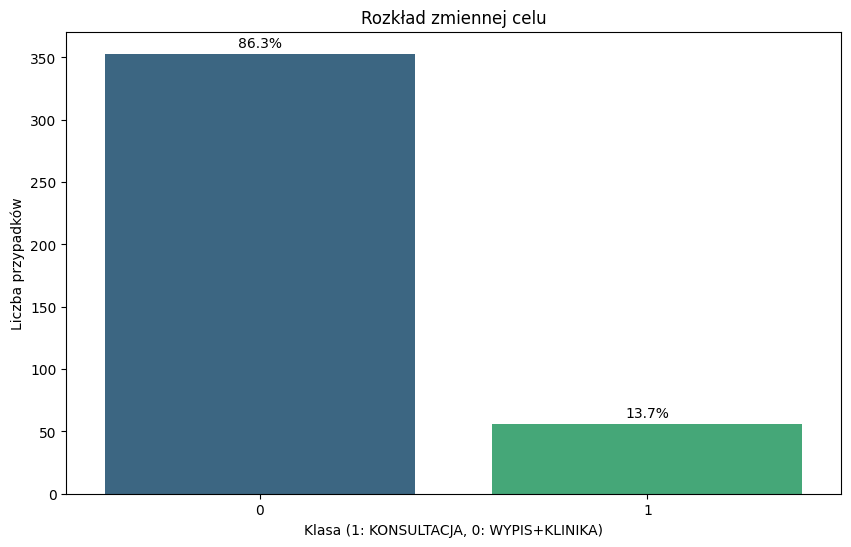

In [380]:
# Binaryzuj zmienną celu zgodnie z wymaganiami zadania
# CONSULT (najważniejsza klasa) staje się 1, DISCHARGE i CLINIC stają się 0
data['binary_target'] = data['TRIAGE'].apply(lambda x: 1 if x == 'CONSULT' else 0)

# Usuń oryginalną kolumnę triażu
data.drop(columns=['TRIAGE'], inplace=True)

# Wizualizacja rozkładu zmiennej celu binarnej
visualize(data)

## 3. Przetwarzanie wstępne danych

Teraz, gdy mamy już zdefiniowaną zmienną celu, przygotujmy dane do modelowania poprzez:
1. Identyfikację cech numerycznych i kategorycznych
2. Stworzenie potoków przygotowania cech dla różnych typów danych
3. Konfigurację odpowiedniego przetwarzania brakujących wartości

To przetwarzanie wstępne jest niezbędne do przekształcenia surowych danych medycznych w format odpowiedni dla algorytmów uczenia maszynowego.

In [381]:
# Identyfikacja cech numerycznych i kategorycznych
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns.tolist()

# Usuń zmienną celu z kolumn numerycznych, jeśli jest obecna
numerical_cols.remove('binary_target')

# Wyświetl informacje o typach cech
print(f"Liczba cech numerycznych: {len(numerical_cols)}")
print(f"Liczba cech kategorycznych: {len(categorical_cols)}")
print(f"\nCechy numeryczne: {numerical_cols}")
print(f"\nCechy kategoryczne: {categorical_cols}")

Liczba cech numerycznych: 1
Liczba cech kategorycznych: 28

Cechy numeryczne: ['NUMBER']

Cechy kategoryczne: ['AGE', 'HX_AS', 'NAUSEA', 'VOMIT', 'NAUSEA_OR_VOMIT', 'ABD_PAIN', 'ONSET', 'PAIN_TYPE', 'DURATION', 'ASSOC_UT_SX', 'HX_TRAUMA', 'HX_SPORTS', 'HX_SEX', 'PMHX_UTI', 'PMHX_SURG', 'PMHX_UT_ABN', 'TEMP', 'LOCATION', 'SITE_TENDER', 'SITE_SWELLING', 'COLOR', 'TEST_LIE', 'CORD_PALP', 'CREM_REF', 'TRANSILLUM', 'URINE_WBC', 'URINE_BACT', 'URINE_RBC']


In [382]:
# Podziel dane na cechy i zmienną celu
X = data.drop('binary_target', axis=1)
y = data['binary_target']

## 4. Budowa modelu

### 4.1 Model bazowy (Regresja logistyczna)

Zaczniemy od prostego modelu regresji logistycznej jako punkt odniesienia.
Dla tego modelu bazowego zastosujemy:
- Prostą imputację brakujących wartości
- Kodowanie one-hot zmiennych kategorycznych
- Ważenie klas w celu rozwiązania problemu niezbalansowania

In [383]:
simple_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', SimpleImputer(strategy='median'), numerical_cols)
    ])

baseline_model = Pipeline(steps=[
    ('preprocessor', simple_preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'))  # Obsługa niezbalansowania klas
])

### 4.2 Model zoptymalizowany z przeszukiwaniem siatki (XGBoost)

Dla naszego zoptymalizowanego modelu użyjemy XGBoost.
Wzbogacimy model o:
- Selekcję cech, aby skupić się na najważniejszych predyktorach
- Nadpróbkowanie SMOTE w celu rozwiązania problemu niezbalansowania klas
- Dostrojenie hiperparametrów poprzez przeszukiwanie siatki w celu optymalizacji wydajności

In [384]:
preprocessor_columns = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Wypełnij brakujące wartości medianą
        ('scaler', StandardScaler())  # Normalizuj cechy numeryczne
    ]), numerical_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Wypełnij brakujące wartości kategoryczne
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Kodowanie one-hot cech kategorycznych
    ]), categorical_cols)
])

base_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor_columns),
    ('feature_selection', SelectFromModel(xgb.XGBClassifier(
        n_estimators=50, 
        max_depth=3, 
        random_state=RANDOM_STATE))),  # Użyj XGBoost do selekcji cech
    ('smote', SMOTE(random_state=RANDOM_STATE)),  # Nadpróbkowanie klasy mniejszościowej
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        scale_pos_weight=2.0  # Waga dla rozwiązania niezbalansowania klas
    ))
])

param_grid = {
    # Testuj różne metody skalowania dla cech numerycznych
    'preprocessor__num__scaler': [StandardScaler(), QuantileTransformer(n_quantiles=100, output_distribution='normal')],

    # Testuj różne rozmiary sąsiedztwa dla SMOTE
    'smote__k_neighbors': [3, 5],
    
    # Testuj różne hiperparametry XGBoost
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 4],
    'classifier__scale_pos_weight': [2.0, 3.0],
}

scoring = {'auprc': 'average_precision', 'auroc': 'roc_auc'}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='auprc',  # Optymalizuj pod kątem AUPRC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X, y)
optimized_model = grid_search.best_estimator_

print("Najlepsze parametry:", grid_search.best_params_)
print(f"Najlepszy ROC AUC: {grid_search.best_score_:.4f}")

Fitting 15 folds for each of 64 candidates, totalling 960 fits
Najlepsze parametry: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 50, 'classifier__scale_pos_weight': 2.0, 'preprocessor__num__scaler': StandardScaler(), 'smote__k_neighbors': 5}
Najlepszy ROC AUC: 0.5467


## 5. Ocena modelu (3-krotna stratyfikowana walidacja krzyżowa z 5 podziałami)

Zaimplementujemy framework oceny zgodnie z wymaganiami zadania:
1. Użyj 3-krotnie powtórzonej stratyfikowanej walidacji krzyżowej z 5 podziałami
2. Dla każdego podziału:
   - Trenuj modele na zbiorze treningowym
   - Oblicz progi ryzyka na zbiorze treningowym
   - Zastosuj progi do predykcji zbioru testowego
   - Oblicz metryki (AUPRC, AUROC, FNR, FPR itp.)
3. Uśrednij metryki ze wszystkich podziałów

In [385]:
def find_threshold_for_sensitivity(y_true, y_scores, min_sensitivity=0.99):
    """
    Znajdź próg, dla którego czułość (recall) jest >= min_sensitivity
    
    Argumenty:
        y_true: Prawdziwe etykiety klas
        y_scores: Wyniki predykcji (prawdopodobieństwa)
        min_sensitivity: Minimalna wymagana czułość
        
    Zwraca:
        Próg, który osiąga pożądaną czułość
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Znajdź indeksy, gdzie recall (czułość) spełnia minimalne wymaganie
    valid_indices = recall >= min_sensitivity
    valid_thresholds = thresholds[valid_indices[:-1]]  # Krzywa precision-recall zwraca o jeden punkt więcej niż próg
    
    if len(valid_thresholds) > 0:
        # Zwróć najwyższy próg, który spełnia wymaganie czułości (najbardziej restrykcyjny)
        return max(valid_thresholds)


def find_threshold_for_specificity(y_true, y_scores, min_specificity=0.90):
    """
    Znajdź próg, dla którego swoistość jest >= min_specificity
    
    Argumenty:
        y_true: Prawdziwe etykiety klas
        y_scores: Wyniki predykcji (prawdopodobieństwa)
        min_specificity: Minimalna wymagana swoistość
        
    Zwraca:
        Próg, który osiąga pożądaną swoistość
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Konwertuj FPR na swoistość (1-FPR)
    specificity = 1 - fpr
    
    # Znajdź indeksy, gdzie swoistość spełnia minimalne wymaganie
    valid_indices = specificity >= min_specificity
    valid_thresholds = thresholds[valid_indices]
    
    if len(valid_thresholds) > 0:
        # Zwróć najniższy próg, który spełnia wymaganie swoistości (najmniej restrykcyjny)
        return min(valid_thresholds)


def apply_thresholds(y_scores, medium_risk_threshold, high_risk_threshold):
    """
    Zastosuj progi ryzyka do wyników klasyfikatora, aby utworzyć trzyklasową decyzję:
    - Niskie ryzyko (decyzja negatywna)
    - Średnie ryzyko (szara strefa - brak decyzji)
    - Wysokie ryzyko (decyzja pozytywna)
    
    Argumenty:
        y_scores: Wyniki predykcji (prawdopodobieństwa)
        medium_risk_threshold: Próg dla średniego ryzyka (czułość >= 99%)
        high_risk_threshold: Próg dla wysokiego ryzyka (swoistość >= 90%)
        
    Zwraca:
        Tablicę decyzji i maskę szarej strefy
    """
    decisions = np.full(len(y_scores), None)
    
    # Zastosuj reguły decyzyjne oparte na progach
    decisions[y_scores < medium_risk_threshold] = 0  # Negatywne
    decisions[y_scores >= high_risk_threshold] = 1   # Pozytywne
    
    # Utwórz maskę dla szarej strefy (przykłady bez jasnej decyzji)
    grey_zone_mask = (decisions != 0) & (decisions != 1)
    
    return decisions, grey_zone_mask

def calculate_metrics(y_true, decisions, grey_zone_mask):
    """
    Oblicz metryki wydajności dla sklasyfikowanych przykładów (z wyłączeniem szarej strefy)
    
    Argumenty:
        y_true: Prawdziwe etykiety klas
        decisions: Decyzje klasyfikatora (0, 1 lub None)
        grey_zone_mask: Maska wskazująca przykłady w szarej strefie
        
    Zwraca:
        Słownik metryk
    """

    classified_mask = ~grey_zone_mask
    y_true_classified = y_true[classified_mask]
    decisions_classified = decisions[classified_mask]

    if len(y_true_classified) == 0:
        return {
            'fnr': np.nan,
            'fpr': np.nan,
            'pct_negative': 0.0,
            'pct_positive': 0.0,
            'pct_grey_zone': 100.0
        }
    
    tp = np.sum((y_true_classified == 1) & (decisions_classified == 1))
    tn = np.sum((y_true_classified == 0) & (decisions_classified == 0))
    fp = np.sum((y_true_classified == 0) & (decisions_classified == 1))
    fn = np.sum((y_true_classified == 1) & (decisions_classified == 0))
    
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # Współczynnik fałszywie negatywnych
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # Współczynnik fałszywie pozytywnych
    
    total_examples = len(decisions)
    pct_negative = np.sum(decisions == 0) / total_examples * 100
    pct_positive = np.sum(decisions == 1) / total_examples * 100
    pct_grey_zone = np.sum(grey_zone_mask) / total_examples * 100
    
    return {
        'fnr': fnr,
        'fpr': fpr,
        'pct_negative': pct_negative,
        'pct_positive': pct_positive,
        'pct_grey_zone': pct_grey_zone
    }

## 5. Kompletny framework oceny

Teraz zaimplementujemy kompletny framework oceny używając 3-krotnej stratyfikowanej walidacji krzyżowej z 5 podziałami, zgodnie z wymaganiami zadania. Zapewni to solidną ocenę wydajności modelu na wielu podziałach danych.

In [386]:
def evaluate_classifier(classifier, X, y, n_splits=5, n_repeats=3, random_state=RANDOM_STATE):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    results_auprc = []
    results_auroc = []
    results_fnr = []
    results_fpr = []
    results_pct_negative = []
    results_pct_positive = []
    results_pct_grey_zone = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        classifier.fit(X_train, y_train)
        
        y_train_scores = classifier.predict_proba(X_train)[:, 1]
        y_test_scores = classifier.predict_proba(X_test)[:, 1]

        precision, recall, _ = precision_recall_curve(y_test, y_test_scores)
        auprc = auc(recall, precision)
        
        fpr, tpr, _ = roc_curve(y_test, y_test_scores)
        auroc = auc(fpr, tpr)
        
        medium_risk_threshold = find_threshold_for_sensitivity(y_train, y_train_scores, min_sensitivity=0.99)
        high_risk_threshold = find_threshold_for_specificity(y_train, y_train_scores, min_specificity=0.90)

        decisions, grey_zone_mask = apply_thresholds(y_test_scores, medium_risk_threshold, high_risk_threshold)
        
        metrics = calculate_metrics(y_test.values, decisions, grey_zone_mask)
        
        results_auprc.append(auprc)
        results_auroc.append(auroc)
        results_fnr.append(metrics['fnr'])
        results_fpr.append(metrics['fpr'])
        results_pct_negative.append(metrics['pct_negative'])
        results_pct_positive.append(metrics['pct_positive'])
        results_pct_grey_zone.append(metrics['pct_grey_zone'])
        
    avg_results = {
        'auprc': np.mean(results_auprc),
        'auroc': np.mean(results_auroc),
        'fnr': np.mean(results_fnr),
        'fpr': np.mean(results_fpr),
        'pct_negative': np.mean(results_pct_negative),
        'pct_positive': np.mean(results_pct_positive),
        'pct_grey_zone': np.mean(results_pct_grey_zone),
        'std_auprc': np.std(results_auprc),
        'std_auroc': np.std(results_auroc),
        'all_iterations': {
            'auprc': results_auprc,
            'auroc': results_auroc,
            'fnr': results_fnr,
            'fpr': results_fpr,
            'pct_negative': results_pct_negative,
            'pct_positive': results_pct_positive,
            'pct_grey_zone': results_pct_grey_zone
        }
    }
    
    return avg_results

In [387]:
print("Ocena modelu bazowego (Regresja Logistyczna)")
baseline_results = evaluate_classifier(baseline_model, X, y)

print("Ocena zoptymalizowanego modelu po dostrojeniu hiperparametrów (XGBoost z przeszukiwaniem siatki)")
grid_search_results = evaluate_classifier(optimized_model, X, y)

Ocena modelu bazowego (Regresja Logistyczna)
Ocena zoptymalizowanego modelu po dostrojeniu hiperparametrów (XGBoost z przeszukiwaniem siatki)


## 6. Wizualizacja wyników

Porównajmy wydajność modelu bazowego i zoptymalizowanego za pomocą wizualizacji.
Te wizualizacje pomogą nam zrozumieć:
1. Jak modele porównują się pod względem AUPRC i AUROC
2. Współczynniki błędów (FNR i FPR) każdego modelu
3. Rozkład decyzji (pozytywne, negatywne, szara strefa)

In [388]:
def plot_metrics_comparison(baseline_results, improved_results):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    metrics = ['auprc', 'auroc']
    titles = ['Pole pod krzywą Precision-Recall (AUPRC)', 'Pole pod krzywą ROC (AUROC)']

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        baseline_metric = baseline_results[metric]
        improved_metric = improved_results[metric]
        baseline_std = baseline_results[f'std_{metric}']
        improved_std = improved_results[f'std_{metric}']
        
        ax[i].bar([0, 1], [baseline_metric, improved_metric], 
                 yerr=[baseline_std, improved_std],
                 capsize=10, color=['#3498db', '#2ecc71'], 
                 width=0.5)
        
        ax[i].set_title(title, fontsize=14)
        ax[i].set_xticks([0, 1])
        ax[i].set_xticklabels(['Model bazowy', 'Model zoptymalizowany'], fontsize=12)
        ax[i].set_ylim([0, 1])
        ax[i].set_ylabel('Wartość', fontsize=12)
        
        for j, v in enumerate([baseline_metric, improved_metric]):
            ax[i].text(j, v + 0.05 + (improved_std if j==1 else baseline_std), 
                      f"{v:.4f}", ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['fnr', 'fpr']
    titles = ['Współczynnik fałszywie negatywnych (FNR)', 'Współczynnik fałszywie pozytywnych (FPR)']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        baseline_metric = baseline_results[metric]
        improved_metric = improved_results[metric]
        
        ax[i].bar([0, 1], [baseline_metric, improved_metric], 
                 color=['#3498db', '#2ecc71'], 
                 width=0.5)
        
        ax[i].set_title(title, fontsize=14)
        ax[i].set_xticks([0, 1])
        ax[i].set_xticklabels(['Model bazowy', 'Model zoptymalizowany'], fontsize=12)
        ax[i].set_ylim([0, 1])
        ax[i].set_ylabel('Wartość', fontsize=12)
        
        for j, v in enumerate([baseline_metric, improved_metric]):
            ax[i].text(j, v + 0.05, f"{v:.4f}", ha='center', fontsize=12)
    
    width = 0.35
    baseline_classes = [baseline_results['pct_negative'], baseline_results['pct_positive'], baseline_results['pct_grey_zone']]
    improved_classes = [improved_results['pct_negative'], improved_results['pct_positive'], improved_results['pct_grey_zone']]
    
    x = np.arange(3)
    ax[2].bar(x - width/2, baseline_classes, width, label='Model bazowy', color='#3498db')
    ax[2].bar(x + width/2, improved_classes, width, label='Model zoptymalizowany', color='#2ecc71')
    
    ax[2].set_title('Rozkład klasyfikacji', fontsize=14)
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(['Negatywne', 'Pozytywne', 'Szara strefa'], fontsize=12)
    ax[2].set_ylabel('Procent przykładów [%]', fontsize=12)
    ax[2].set_ylim([0, 100])
    ax[2].legend()
    
    for i, (b_v, i_v) in enumerate(zip(baseline_classes, improved_classes)):
        ax[2].text(i - width/2, b_v + 3, f"{b_v:.1f}%", ha='center', fontsize=10)
        ax[2].text(i + width/2, i_v + 3, f"{i_v:.1f}%", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

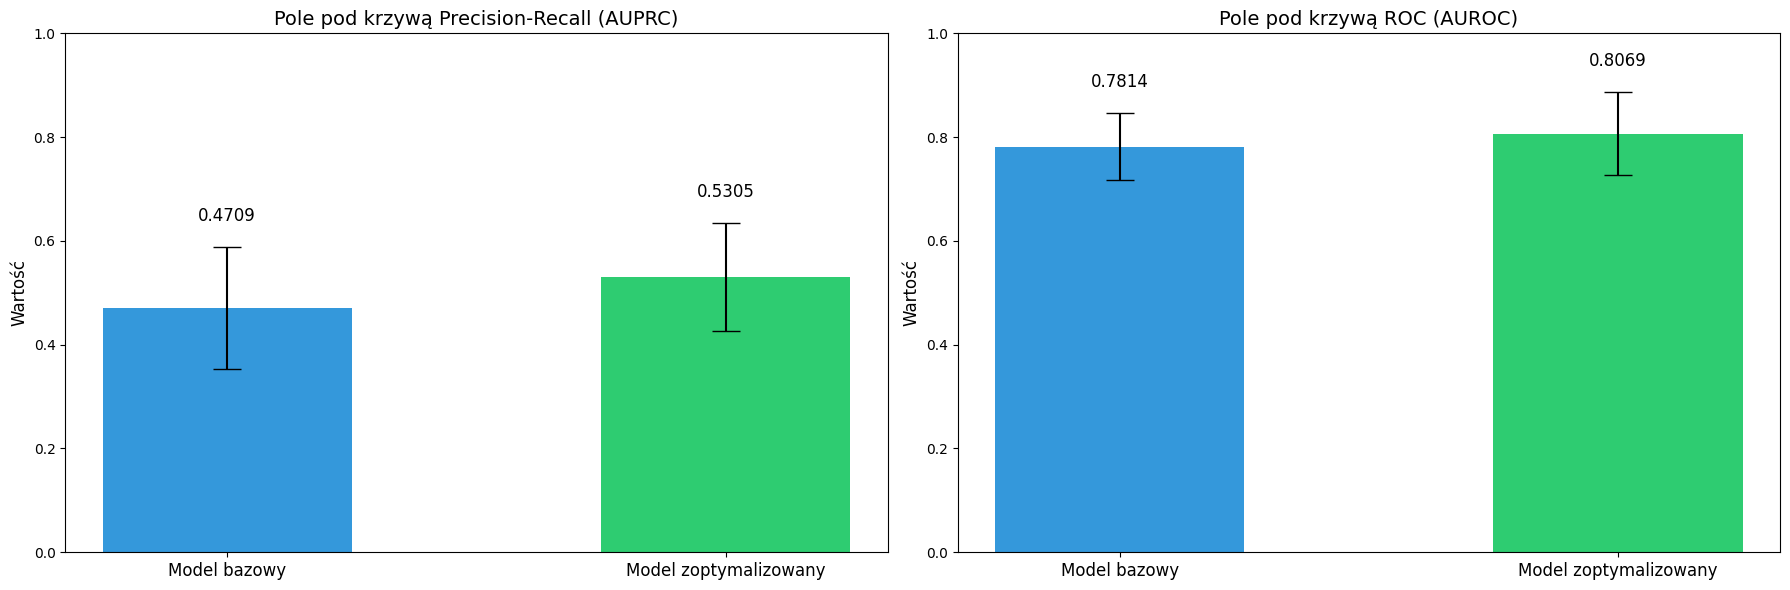

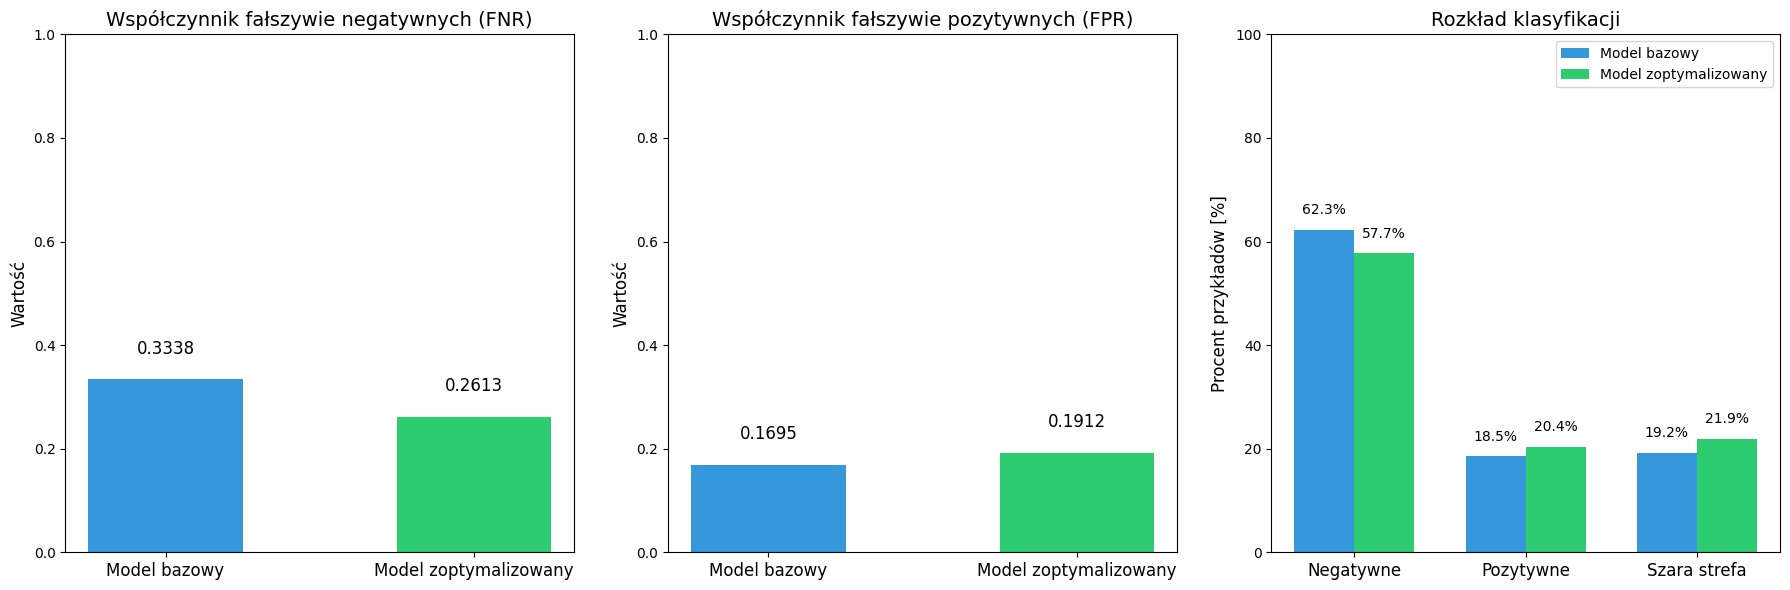


Wyniki modelu bazowego (Regresja Logistyczna):
AUPRC: 0.4709 ± 0.1180
AUROC: 0.7814 ± 0.0644
Współczynnik fałszywie negatywnych: 0.3338
Współczynnik fałszywie pozytywnych: 0.1695
Procent sklasyfikowany jako negatywny: 62.3%
Procent sklasyfikowany jako pozytywny: 18.5%
Procent w szarej strefie: 19.2%

Wyniki modelu zoptymalizowanego (XGBoost z przeszukiwaniem siatki):
AUPRC: 0.5305 ± 0.1044
AUROC: 0.8069 ± 0.0802
Współczynnik fałszywie negatywnych: 0.2613
Współczynnik fałszywie pozytywnych: 0.1912
Procent sklasyfikowany jako negatywny: 57.7%
Procent sklasyfikowany jako pozytywny: 20.4%
Procent w szarej strefie: 21.9%


In [389]:
plot_metrics_comparison(baseline_results, grid_search_results)

print("\nWyniki modelu bazowego (Regresja Logistyczna):")
print(f"AUPRC: {baseline_results['auprc']:.4f} ± {baseline_results['std_auprc']:.4f}")
print(f"AUROC: {baseline_results['auroc']:.4f} ± {baseline_results['std_auroc']:.4f}")
print(f"Współczynnik fałszywie negatywnych: {baseline_results['fnr']:.4f}")
print(f"Współczynnik fałszywie pozytywnych: {baseline_results['fpr']:.4f}")
print(f"Procent sklasyfikowany jako negatywny: {baseline_results['pct_negative']:.1f}%")
print(f"Procent sklasyfikowany jako pozytywny: {baseline_results['pct_positive']:.1f}%")
print(f"Procent w szarej strefie: {baseline_results['pct_grey_zone']:.1f}%")

print("\nWyniki modelu zoptymalizowanego (XGBoost z przeszukiwaniem siatki):")
print(f"AUPRC: {grid_search_results['auprc']:.4f} ± {grid_search_results['std_auprc']:.4f}")
print(f"AUROC: {grid_search_results['auroc']:.4f} ± {grid_search_results['std_auroc']:.4f}")
print(f"Współczynnik fałszywie negatywnych: {grid_search_results['fnr']:.4f}")
print(f"Współczynnik fałszywie pozytywnych: {grid_search_results['fpr']:.4f}")
print(f"Procent sklasyfikowany jako negatywny: {grid_search_results['pct_negative']:.1f}%")
print(f"Procent sklasyfikowany jako pozytywny: {grid_search_results['pct_positive']:.1f}%")
print(f"Procent w szarej strefie: {grid_search_results['pct_grey_zone']:.1f}%")

# 7. Interpretacja wyników modeli klasyfikacyjnych dla triaży medycznej

Porównanie obu modeli pozwala na wyciągnięcie istotnych wniosków w kontekście wspomagania decyzji medycznych.

## Ogólna poprawa skuteczności

Model z Grid Search wykazuje znaczącą poprawę w stosunku do modelu bazowego:
* **AUPRC wzrósł o 12.7%** (z 0.4709 do 0.5305) - lepsze równoważenie precyzji i czułości
* **AUROC wzrósł o 3.3%** (z 0.7814 do 0.8069) - lepsza zdolność rozróżniania klas

## Kluczowe wskaźniki kliniczne

1. **Redukcja wskaźnika fałszywie negatywnych (FNR)**:
   * Spadek o 21.7% (z 0.3338 do 0.2613)
   * **Znaczenie kliniczne**: Mniejsza liczba pacjentów wymagających pilnej uwagi zostanie błędnie sklasyfikowana jako przypadki niskiego ryzyka, co jest kluczowe dla bezpieczeństwa pacjentów

2. **Nieznaczny wzrost wskaźnika fałszywie pozytywnych (FPR)**:
   * Wzrost o 12.8% (z 0.1695 do 0.1912)
   * **Znaczenie kliniczne**: Akceptowalny kompromis - lepiej skierować kilku pacjentów więcej do dokładniejszej oceny niż przeoczyć przypadki krytyczne

## Rozkład klasyfikacji

1. **Mniej przypadków jednoznacznie negatywnych**:
   * Spadek z 62.3% do 57.7%
   * Model jest bardziej ostrożny w oznaczaniu pacjentów jako niewymagających uwagi

2. **Więcej przypadków jednoznacznie pozytywnych**:
   * Wzrost z 18.5% do 20.4%
   * Model identyfikuje więcej przypadków wysokiego ryzyka

3. **Nieznacznie większa strefa szara**:
   * Wzrost z 19.2% do 21.9%
   * Więcej przypadków wymaga dodatkowej oceny klinicznej

## Implikacje praktyczne w kontekście triaży SOR

1. **Bezpieczeństwo pacjentów**:
   * Nowy model jest lepiej dostosowany do priorytetów klinicznych, gdzie przeoczenie przypadku pilnego jest bardziej problematyczne niż zbędne skierowanie
   
2. **Obciążenie pracą**:
   * Nieznaczny wzrost przypadków wymagających dokładniejszej oceny (zarówno pozytywnych, jak i w szarej strefie) może zwiększyć obciążenie, ale jest to uzasadnione poprawą bezpieczeństwa

3. **Stabilność predykcji**:
   * Mniejsze odchylenie standardowe dla AUPRC (±0.1044 vs ±0.1180) wskazuje na większą spójność wyników między różnymi podzbiorami danych

## Podsumowanie

Model z Grid Search stanowi istotną poprawę w kontekście medycznym, szczególnie poprzez znaczące zmniejszenie wskaźnika fałszywie negatywnych wyników przy akceptowalnym wzroście fałszywie pozytywnych. Taki kompromis jest pożądany w środowisku triaży szpitalnego oddziału ratunkowego, gdzie priorytetem jest bezpieczeństwo pacjenta.

Warto zauważyć, że szara strefa (21.9%) jest wciąż na rozsądnym poziomie, pozwalając klinicystom skupić się na przypadkach wymagających dodatkowej oceny, co jest zgodne z podejściem "lepiej dmuchać na zimne" w kontekście medycznym.